In [ ]:
'''
The goal of this notebook is to identify what features contribute to wine quality

And to get the best prodictor that can identify high quality wines.
High accuracy with ability to identify quality=8 wines is ideal
However due to class imbalance, quality=7 is still acceptable

'''

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display
from sklearn.base import BaseEstimator, ClassifierMixin, clone, is_classifier
from sklearn.base import MultiOutputMixin
from sklearn.base import MetaEstimatorMixin, is_regressor
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils.deprecation import deprecated
from sklearn.utils._tags import _safe_tags
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import (
    _check_partial_fit_first_call,
    type_of_target
)
from sklearn.utils.metaestimators import _safe_split, available_if
from sklearn.utils.fixes import delayed
from sklearn.multiclass import (
    _fit_binary,
    _fit_ovo_binary,

    _estimators_has
)
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas_profiling
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


# 2. EDA #

In [2]:
# eda
df_red = pd.read_csv('winequality-red.csv', delimiter=';')
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df_red['type'] = 0
df_white['type'] = 1
df_both = pd.concat([df_red, df_white])

X_red = df_red.drop(columns="quality")
X_white = df_white.drop(columns="quality")
X_both = df_both.drop(columns="quality")
y_red = df_red["quality"]
y_white = df_white["quality"]
y_both = df_both['quality']


In [110]:
wine_report=pandas_profiling.ProfileReport(df_red)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [71]:
wine_report.to_file('wines_eda.html')

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type'],
      dtype='object')

# 3. Data Preparation - Feature Engineering #

In [131]:
## FE
'''
create total-free sulfur dioxide for contained so2?

'''
# change this for white or both
X_df = X_red
y_df = y_red

# remove nulls
for col in X_df.columns:
  if X_df[col].isnull().sum() > 0:
    X_df[col] = X_df[col].fillna(X_df[col].mean())

### Feature testing ###
def featurize(df):
  df['contained sulfur dioxide'] = df['total sulfur dioxide'] - df['free sulfur dioxide']

  df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
  df['acid/density'] = df['total_acid']  / df['density']
  df['alcohol_density'] = df['alcohol']  * df['density']
  df['sulphate/density'] = df['sulphates']  / df['density']
  df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
  df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
  df['sulphates*alcohol'] = df['sulphates'] * df['alcohol']
  #df['sugar/acid'] = df['residual sugar']/ df['total_acid']


  orig_features=["fixed acidity", "volatile acidity", "citric acid","residual sugar",
              "chlorides","free sulfur dioxide",
              #"total sulfur dioxide",
                "density","pH","sulphates","alcohol"
                #, "sugar/acid"
                ]

  new_features=['total_acid','acid/density','alcohol_density','sulphate/density',
              'sulphates/acid','sulphates/chlorides','sulphates*alcohol',
              'contained sulfur dioxide']

  wine_features = orig_features + new_features

  return df[wine_features]


X_df = featurize(X_df)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.24)
sc = MinMaxScaler(feature_range = (0, 1))
X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test_sc = pd.DataFrame(sc.fit_transform(X_test),columns = X_test.columns)

# 4/5. Model Selection and Evaluation #

## Linear Regression ##

### Linear Regression - Random Forest ###

In [61]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

regressor.fit(X_train, y_train)



RandomForestRegressor(random_state=0)

In [62]:
Y_prediction = regressor.predict(X_test) # test the output by changing values


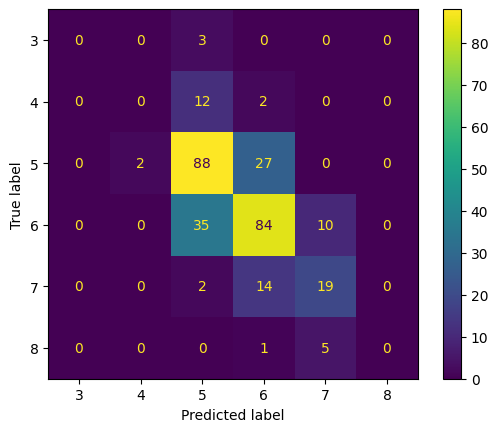

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, np.rint(Y_prediction))

disp = ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8])

disp.plot()

plt.show()


In [139]:
# Lets smote it!
from imblearn.over_sampling import SMOTE

X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)


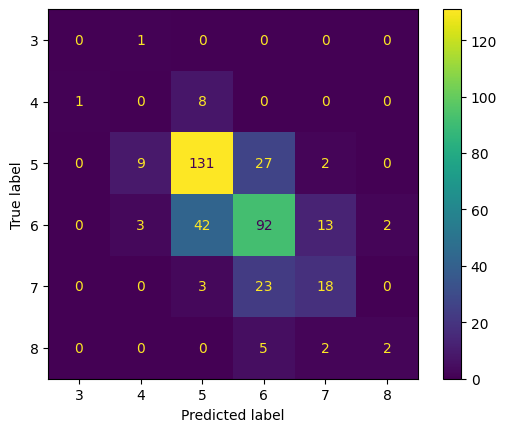

In [140]:
regressor.fit(X_train_smote, y_train_smote)
Y_prediction = regressor.predict(X_test) # test the output by changing values

cm = confusion_matrix(y_test, np.rint(Y_prediction))

disp = ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8])

disp.plot()

#SMOTE doesnt help the regression model
plt.show()

## Multiclass Classifier ##

In [141]:
xgb_multi = xgb.XGBClassifier(objective="multi:softmax")

xgb_multi.fit(X_train_smote, (y_train_smote-3))
xgb_multi_pred = xgb_multi.predict(X_test)

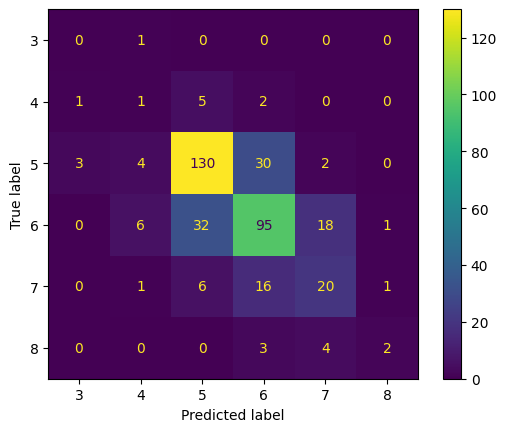

In [142]:
cm = confusion_matrix(y_test, xgb_multi_pred+3)

disp = ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8])

disp.plot()

# xgb predicted a few 8s but not the right ones, has no idea about ordinality
plt.show()

## Ordinal Classifier ##

In [46]:
class OrdinalClassifier():

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        return np.vstack(predicted).T

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)

In [47]:
xgb_clf_ord = xgb.XGBClassifier()

clf = OrdinalClassifier(xgb_clf_ord)

clf.fit(X_train_smote, y_train_smote)

xgb_ord_pred = clf.predict(X_test)

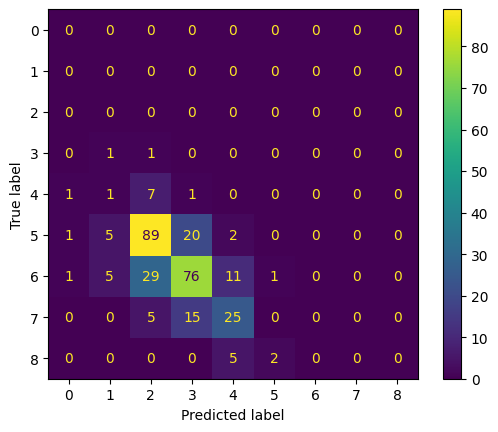

In [48]:
cm = confusion_matrix(y_test, xgb_ord_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4,5,6,7,8])

disp.plot()

# ordinal classifier performs very poorly and seems to have a bias
plt.show()

## Binary Classifier ##

In [122]:
## create binary data objects

# change this for white or both
df_red['binary_quality'] = [ 1 if x>=7 else 0 for x in df_red.quality]
X_red_bin = df_red.drop(columns=['quality','binary_quality'])

X_df = X_red_bin
y_df = df_red['binary_quality']


from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

X_df = featurize(X_df)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.19)
#sc = MinMaxScaler(feature_range=(0,1))
sc = QuantileTransformer(output_distribution="normal")
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

X_train_sc = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_train_smote_sc = pd.DataFrame(sc.fit_transform(X_train_smote),columns = X_train_smote.columns)
X_test_sc = pd.DataFrame(sc.fit_transform(X_test),columns = X_test.columns)

/Users/darcy/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(


In [128]:
xgb_clf_bin = xgb.XGBClassifier()

xgb_clf_bin.fit(X_train_smote, y_train_smote)

xgb_bin_pred = xgb_clf_bin.predict(X_test)

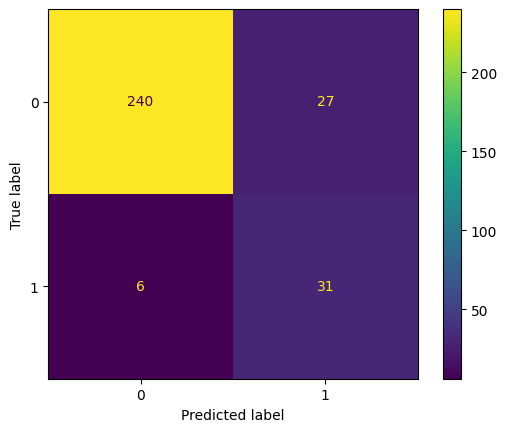

In [129]:
cm = confusion_matrix(y_test, xgb_bin_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])

disp.plot()

plt.show()

In [116]:
svc_clf_bin = SVC()

svc_clf_bin.fit(X_train_smote_sc, y_train_smote)

svc_bin_pred = svc_clf_bin.predict(X_test_sc)

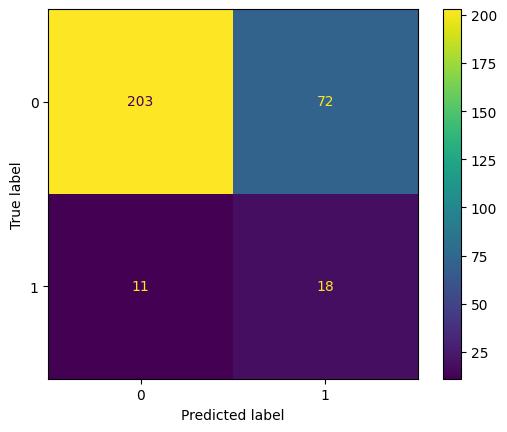

In [117]:
cm = confusion_matrix(y_test, svc_bin_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])

disp.plot()

plt.show()

In [86]:
dt_clf_bin = DecisionTreeClassifier()
dt_clf_bin.fit(X_train, y_train)

dt_bin_pred = dt_clf_bin.predict(X_test)

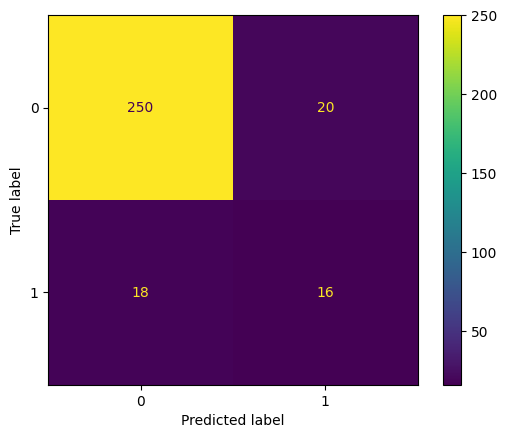

In [87]:
cm = confusion_matrix(y_test, dt_bin_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])

disp.plot()

plt.show()

### XGB optimisation ###

In [89]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread': [4],
              'objective': ["binary:logistic"],
              'learning_rate': [0.02,0.04,0.06,0.08],
              'max_depth': [6,10,20,40,100],
              'min_child_weight': [1,2,5,11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5,10,20,40,100,500,1000],
              'scale_pos_weight': [1, 20, 50, 100]
              }

xgb_clf = xgb.XGBClassifier()

grid = GridSearchCV(xgb_clf, parameters, n_jobs=4,
                   cv=2,
                   scoring='f1',
                   verbose=2, refit=True)


In [90]:
grid.fit(X_train, y_train)

Fitting 2 folds for each of 2240 candidates, totalling 4480 fits
[15:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=5, nthread=4, objective=binary:logistic, scale_pos_weight=1, silent=1, subsample=0.8; total time=   0.0s
[15:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV] END colsample_bytree=0.7, learning_rate=0.02, max_depth=6, min_child_weight=1, n_estimators=5, nthread=4, objective=binary:logistic, scale_pos_weight=50, silent=1, subsample=0.8; total time=   0.0s
[15:31:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not 

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.02, 0.04, 0.06, 0.08],
                         'max_depth': [6, 10, 20, 40, 100],
                         'min_child_weight': [1, 2, 5, 11],
                         'n_estimators': [5, 10, 20, 40, 100, 500, 1000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'scale_pos_weight': [1, 20, 50, 100], 'silent': [1],
                         'subsample': [0.8]},
             scoring='f1', verbose=2)

In [110]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.08,
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 100,
 'nthread': 4,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8}

In [111]:
best_params = grid.best_params_

xgb_clf_bin = xgb.XGBClassifier(**best_params,
                                scale_pos_weight = 99
                                )

xgb_clf_bin.fit(X_train, y_train)

xgb_bin_pred = xgb_clf_bin.predict(X_test)

cm = confusion_matrix(y_test, xgb_bin_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])

disp.plot()

plt.show()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5], got [3 4 5 6 7 8]